# STUDENT - what is going on below?

You need to read this Notebook and assume that a colleague has asked you for a code review. What is potentially most damaging to their ongoing productivity and correctness? 

* How does this compare to the eda notebook in the previous session?
  * Are the diagrams more useful?
  * Is the code better organised and tested?
  * Are the comments more useful?
  * What could be _1 more thing_ you'd recommend get improved?

----

# Analysis of household air-moisture levels

As part of an ongoing analysis to derive metadata from a timeseries we're using some household data at the 1 minute level to display temperature & humidity levels in our house in 2 rooms.

We then back-calculate the moisture level (grams per metre cubed) for the actual amount of water in a cubed meter or air near the sensor, to get an understanding of where the most or least water is in the house and which household events affect these levels.

We can use similar processes to derive signals for work-releated problems on our own timeseries data, this analysis combines both work and play and will be used as an internal proof-of-concept to get sign-off from the team for running a similar project on internal business data.

**GOAL We've confirmed that we can calculate water content in the air, can we clearly show that the water-content change is different in different rooms and it is connected to explainable behaviour?**

In [1]:
import pandas as pd
import pandera as pa
import matplotlib.pyplot as plt

from utility import (
    make_max_water_by_temp_dataframe,
    set_common_mpl_styles,
    load_data,
    plot_day,
    make_estimated_water_plot,
    make_bin_edges,
    make_bootstrap,
)

FILENAME_KITCHEN = "Kitchen_export_202112311652.csv"
FILENAME_HALL = "First floor hall_export_202112311700.csv"

# Visually confirm that higher temperatures can hold larger amounts of water

Air at higher temperatures holds a non-linearly increasing amount of water compared to water at colder temperatures which makes interpreting relative humidity tricky if you want to guess how much water is actually in the air.

In [2]:
def add_actual_water_content(df, df_moisture):
    df_water = pd.merge_asof(
        df.sort_values("t_c"), df_moisture, left_on="t_c", right_index=True
    ).sort_index()
    df_water["est_water_gm3"] = df_water["max_water_gm3"] * df_water["rh"] / 100
    return df_water

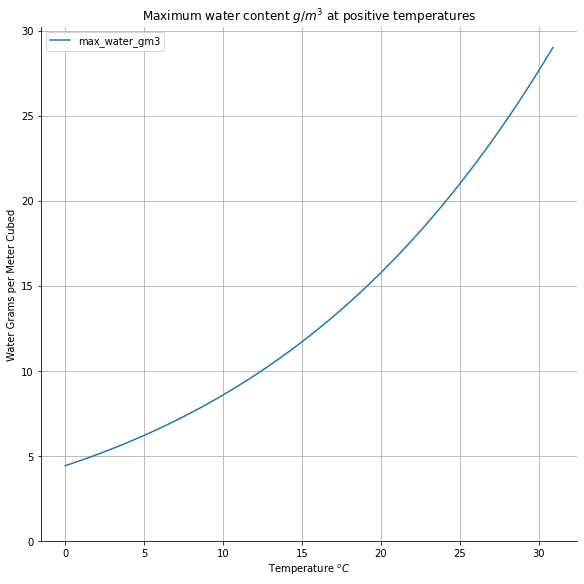

In [3]:
df_moisture = make_max_water_by_temp_dataframe()

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
df_moisture.plot(y="max_water_gm3", ax=ax)
title = "Maximum water content $g/m^3$ at positive temperatures"
set_common_mpl_styles(
    ax,
    title=title,
    xlabel="Temperature $^oC$",
    ylabel="Water Grams per Meter Cubed",
    grid_axis="both",
    ymin=0,
)

# Load kitchen data

In [4]:
# STUDENTS - IGNORE THIS CELL FOR NOW, WE'LL COME BACK TO IT
# IGNORE FOR NOW...

def sanity_check_data(df):
    # this is a simpler example, we reset_index to keep the schema simple for a first discussion
    df = df.reset_index()

    min_date = "2021-01-01"
    max_date = "2022-12-12"
    schema = pa.DataFrameSchema(
        {
            "timestamp": pa.Column(
                "datetime64[ns]", checks=[pa.Check.gt(min_date), pa.Check.lt(max_date)]
            ),
            "rh": pa.Column(float, checks=[pa.Check.gt(0), pa.Check.lt(100)]),
        },
        ordered=True,
    )
    validated_df = schema(df, lazy=True)


def sanity_check_data_with_index(df):
    # this time we don't reset_index, so we have to configure our schema
    # to have a pa.Index entry
    min_date = "2021-01-01"
    max_date = "2022-12-12"
    schema = pa.DataFrameSchema(
        {
            "rh": pa.Column(float, checks=[pa.Check.gt(0), pa.Check.lt(100)]),
        },
        index=pa.Index(
            "datetime64[ns]", checks=[pa.Check.gt(min_date), pa.Check.lt(max_date)]
        ),
        ordered=True,
    )
    validated_df = schema(df, lazy=True)

In [5]:
df_raw = load_data(FILENAME_KITCHEN)

# now let's choose a day
day_to_choose = "2021-12-24"
print(f"Working on {day_to_choose}")
assert pd.to_datetime(day_to_choose) > df_raw.index.min(), "Must be in date range"
assert pd.to_datetime(day_to_choose) < df_raw.index.max(), "Must be in date range"

assert df_raw["t_c"].max() < 50, "Never expecting above 50C in the house"
assert (
    df_raw["rh"].min() > 0
), "Relative humidify can't be below 0% saturation in a normal house"

df_raw.head(2)

Date range 2021-12-22 17:00:00 - 2021-12-31 16:52:00
Working on 2021-12-24


,t_c,rh
timestamp,,
2021-12-22 17:00:00,14.0,48.1
2021-12-22 17:01:00,14.0,48.2


In [6]:
df_30min = df_raw.resample("30min").mean()

sanity_check_data(df_30min)
sanity_check_data_with_index(df_30min)

df_30min.tail(2)

,t_c,rh
timestamp,,
2021-12-31 16:00:00,18.266667,69.536667
2021-12-31 16:30:00,18.378261,71.147826


I'm keeping the simple Temperature and Relative humidity plot for now, having cleaned it up, but I'm going to phase it out in the next piece of work. The richer diagnostic displays are at the end of this Notebook.

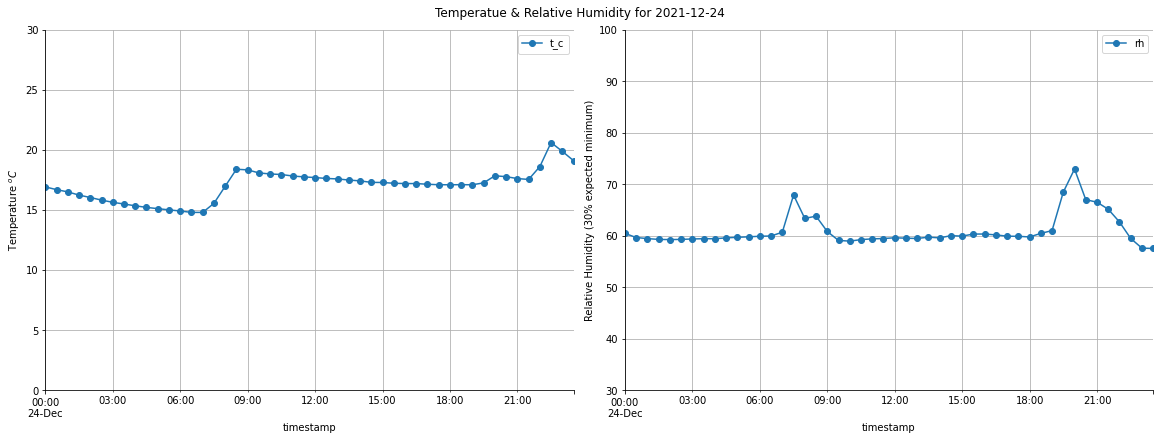

In [7]:
df_day = df_30min.loc[day_to_choose].reset_index()
plot_day(df_day, day_to_choose)

In [8]:
df_30min_water = add_actual_water_content(df_30min, df_moisture)
df_30min_water_kitchen_1day = df_30min_water.loc[day_to_choose]

# Confidence interval on the mean for the kitchen

As an ongoing effort to _introduce confidence bounds to my work_ I'm choosing to add a Confidence Interval to a calculation of the expected temperature in the kitchen. I'm using the bootstrap approach as I'm not sure if I have a Gaussian distribution of temperatures and a bootstrap can give a non-symmertric result in this case, rather than using something like a (Gaussian-assuming) Variance calculation.

In [9]:
# here's an example of bin edges
# so we can see what it is doing
print(make_bin_edges("16.5 16.6 ... 17.5", left_inf=False, right_inf=False))

[16.5 16.6 16.7 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5]


In [10]:
temperatures = df_raw["t_c"].to_numpy()  # to_numpy in preference to .values via flake8

bootstrap_statistics, pc_lower, pc_mid, pc_higher = make_bootstrap(temperatures)

df_means = pd.DataFrame(bootstrap_statistics, columns=["means"])
# we can use friendly functions to make easy-to-read bin ranges
# which align to round numbers, easing their interpretation
bins = make_bin_edges("16.800 16.805 ... 17.0", left_inf=False, right_inf=False)
print(f"Using bins: {bins[:5]}-{bins[-5:]}")

Using bins: [16.8   16.805 16.81  16.815 16.82 ]-[16.98  16.985 16.99  16.995 17.   ]


In the kitchen we _typically_ see a median value of 16.92$^o$C with a 90% confidence interval of 16.91-16.94$^o$C for this data sample (taken in December 2021).

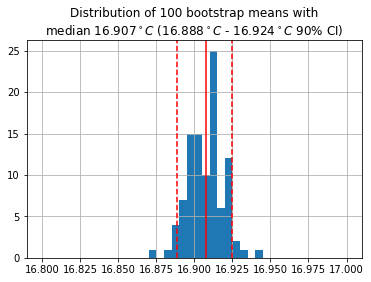

In [11]:
# annoyingly we have to skip the -inf and +inf bins else .hist gets confused!
# by using them
ax = df_means.hist(bins=bins)[0][0]
ax.axvline(pc_lower, c="r", linestyle="--")
ax.axvline(pc_mid, c="r")
ax.axvline(pc_higher, c="r", linestyle="--")
title = f"Distribution of {bootstrap_statistics.shape[0]:,} bootstrap means with"
title += f"\nmedian {pc_mid:0.3f}$^\circ C$ ({pc_lower:0.3f}$^\circ C$ - {pc_higher:0.3f}$^\circ C$ 90% CI)"
ax.set_title(title);

# Do same again for the hallway

In [12]:
df_raw = load_data(FILENAME_HALL)

print(f"Working on {day_to_choose}")
assert pd.to_datetime(day_to_choose) > df_raw.index.min(), "Must be in date range"
assert pd.to_datetime(day_to_choose) < df_raw.index.max(), "Must be in date range"

Date range 2021-12-22 17:00:00 - 2021-12-31 17:00:00
Working on 2021-12-24


In [13]:
df_30min = df_raw.resample("30min").mean()
df_30min_water = add_actual_water_content(df_30min, df_moisture)
df_30min_water_hall_1day = df_30min_water.loc[day_to_choose]

# Compare Kitchen and Hall

We can see that on the 24th December 2021 we were absent from the house during the middle of the day.

* 6.30am the heating comes on and the temperature rises
* 8am we make tea and get son up, releative humidity rises and the moisture content of the air increases
* 9-5pm we're away, the heating is on but nothing adds water into the air as we're absent
* 6pm we get home
* 7pm bath run for the infant (bathroom next to first floor sensor) and humidifier on the first floor turned on both of which add moisture to air, the humidifer runs for 17 hours keeping moisture levels high on the landing on the first floor
* 8pm we cook rice in a pan in the kitchen which adds moisture

__Notice also how in the kitchen between midnight and 6am the estimated water content is decreasing (the same is true in the hallway) - this starts to explain where we're losing moisture in the house environment!__

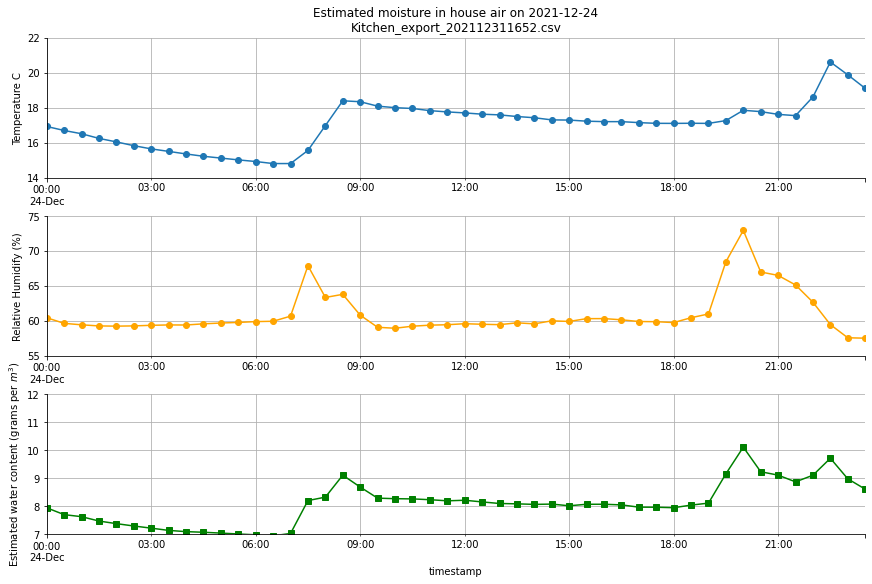

In [14]:
make_estimated_water_plot(df_30min_water_kitchen_1day, FILENAME_KITCHEN, day_to_choose)

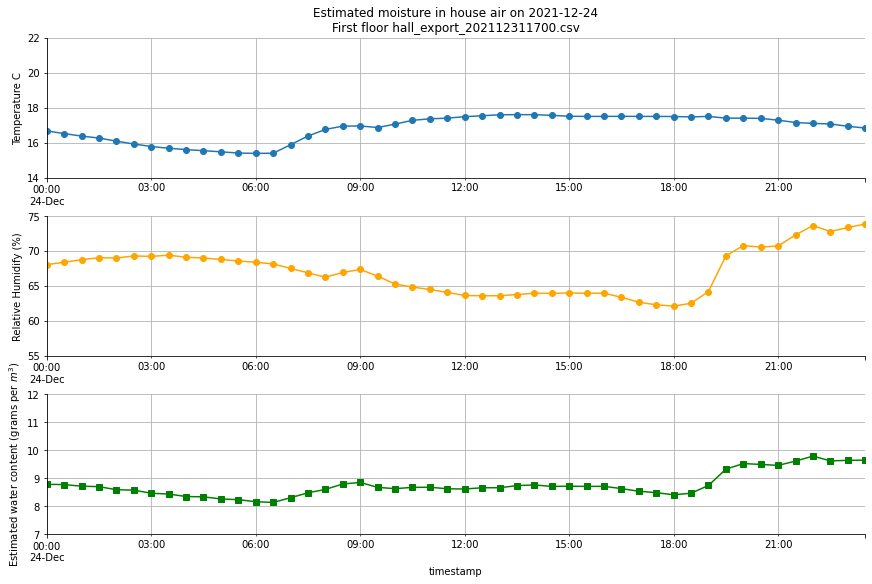

In [15]:
make_estimated_water_plot(df_30min_water_hall_1day, FILENAME_HALL, day_to_choose)